In [8]:
# Install library for reading JPK File
%pip uninstall jpkreader --yes
%pip install git+https://github.com/jlopezalo/pyjpkreader

Found existing installation: jpkreader 0.0.1
Uninstalling jpkreader-0.0.1:
  Successfully uninstalled jpkreader-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyjpkreader to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-tbvbf1ug
  Running command git clone -q https://github.com/jlopezalo/pyjpkreader /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-tbvbf1ug
  Created wheel for jpkreader: filename=jpkreader-0.0.1-py3-none-any.whl size=10194 sha256=4fa38a3c466d4c44a60e5b50fa7de7deb70e44bf9337464713b203f5a07f4e2f
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-ii95kkzi/wheels/23/c0/8e/c378f28c65b0199f6092b6aa45e090c1ed6b4093f3adb03a15
Successfully built jpkreader
Note: you may need to restart the kernel to use updated packages.


In [9]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Found existing installation: pyafmrheo 0.0.1
Uninstalling pyafmrheo-0.0.1:
  Successfully uninstalled pyafmrheo-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-phmz_lip
  Running command git clone -q https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-phmz_lip
  Created wheel for pyafmrheo: filename=pyafmrheo-0.0.1-py3-none-any.whl size=15038 sha256=38124bd80e2ea38664236ae8ac8860520d180316c10f8180bea6d0c80552ebb7
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-g504up8s/wheels/fb/66/18/3e93b45c845b0d7b83ded1e127a1c127820d070ce5b71dece4
Successfully built pyafmrheo
Note: you may need to restart the kernel to use updated packages.


In [10]:
# Install SciPy library for signal processing
%pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [11]:
# Install lmfit for leastsq fitting
%pip install lmfit

Note: you may need to restart the kernel to use updated packages.


In [12]:
# Import libraries we will need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend

# Get file reader from library
from jpkreader import load_jpk_file

# Get data analysis tools
from pyafmrheo.utils.force_curves import *
from pyafmrheo.utils.signal_processing import *
from pyafmrheo.models.rheology import ComputePiezoLag

In [66]:
# Define global variables
file_path = '/Users/javierlopez/Documents/Marseille/29102021/Piezo Characterization - NW3/Pos1/force-save-2021.10.29-16.23.22.656.jpk-force'
# Shapes available: paraboloid, pyramid
indenter_shape = "pyramid"
# tip_parameter = 500 * 1e-9 # meters
tip_parameter = 35 # degrees
# Poisson ratio
poisson_ratio = 0.5
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
# General plotting params
plt.rcParams["figure.figsize"] = (10,5)

In [67]:
file = load_jpk_file(file_path)

In [68]:
file_id = file.file_id
file_type = file.file_type
file_metadata = file.file_metadata
file_data = file.data
piezo_image = file.piezo_image
quality_map = file.quality_map

In [69]:
closed_loop = file_metadata['z_closed_loop_status']
file_deflection_sensitivity = file_metadata['original_deflection_sensitivity'] #nm/V
file_spring_constant = file_metadata['original_spring_constant'] #N/m
height_channel = file_metadata['height_channel_key']

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant

In [70]:
curve_idx = 0
force_curve = file_data[curve_idx]
extend_segments = force_curve.extend_segments
pause_segments = force_curve.pause_segments
modulation_segments = force_curve.modulation_segments
retract_segments = force_curve.retract_segments
force_curve_segments = [*extend_segments, *pause_segments, *modulation_segments, *retract_segments]
force_curve_segments = sorted(force_curve_segments, key=lambda x: int(x[0]))

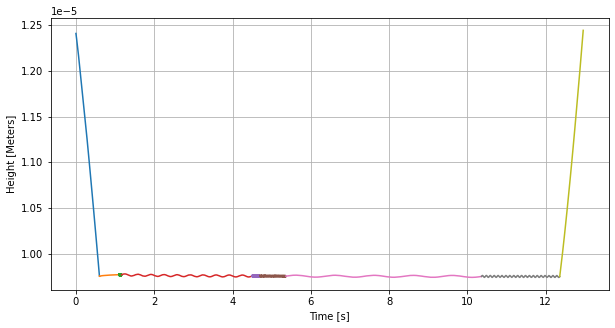

In [71]:
t0 = 0
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, height)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Height [Meters]")
plt.grid()
plt.show()

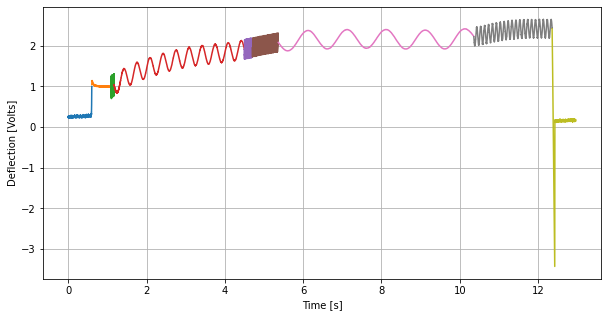

In [72]:
t0 = 0
for seg_id, segment in force_curve_segments:
    deflection = segment.segment_formated_data["vDeflection"]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, deflection)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Deflection [Volts]")
plt.grid()
plt.show()

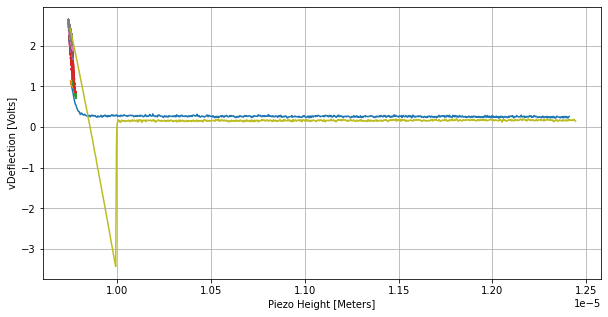

In [73]:
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    deflection = segment.segment_formated_data["vDeflection"]
    plt.plot(height, deflection)

plt.xlabel("Piezo Height [Meters]")
plt.ylabel("vDeflection [Volts]")
plt.grid()
plt.show()

In [74]:
# Get retract, last retract segment
last_ret_seg_id, last_ret_seg = retract_segments[-1]
ret_deflection, ret_height, ret_time =\
    preprocess_segment(last_ret_seg, height_channel, deflection_sensitivity)

if modulation_segments:
    modulation_data = {}
    for seg_id, seg_data in modulation_segments:
        segment_data = {}
        mod_deflection, mod_height, mod_time =\
            preprocess_segment(seg_data, height_channel, deflection_sensitivity)
        segment_data['height'] = mod_height
        segment_data['deflection'] = mod_deflection
        segment_data['time'] = mod_time
        modulation_data[seg_id] = segment_data

In [75]:
# Shift height
xzero = ret_height[-1] # Maximum height
if modulation_segments:
    for segment_data in modulation_data.values():
        segment_data['height'] = xzero - segment_data['height']

In [76]:
help(ComputePiezoLag)

Help on function ComputePiezoLag in module pyafmrheo.models.rheology:

ComputePiezoLag(zheight, deflection, fs, freq, nfft=None, freq_tol=0.0001)



In [80]:
results = []

for seg_id, seg_data in modulation_segments:
    frequency = seg_data.segment_metadata["frequency"]
    data = modulation_data[seg_id]
    time = data['time']
    zheight = data['height']
    delfection = data['deflection']
    deltat = time[1] - time[0]
    fs = 1 / deltat
    ntra_in, ntra_out, ntra_time =\
        detrend_rolling_average(frequency, zheight, delfection, time, 'indentation', 'force', [])
    fi, amp_quotient, gamma2 =\
        ComputePiezoLag(ntra_in, ntra_out, fs, frequency)
    results.append((frequency, fi, amp_quotient, gamma2))

results = sorted(results, key=lambda x: int(x[0]))
frequencies_results = [x[0] for x in results]
fi_results = [x[1] for x in results]
amp_quotient_results = [x[2] for x in results]

The frequency found at index 299.66703662597115 does not match with the frequency applied 300.0
The frequency found at index 2.99625468164794 does not match with the frequency applied 3.0
The frequency found at index 99.94447529150472 does not match with the frequency applied 100.0
The frequency found at index 29.983342587451418 does not match with the frequency applied 30.0
The frequency found at index 0.9966777408637872 does not match with the frequency applied 1.0
The frequency found at index 9.994447529150474 does not match with the frequency applied 10.0


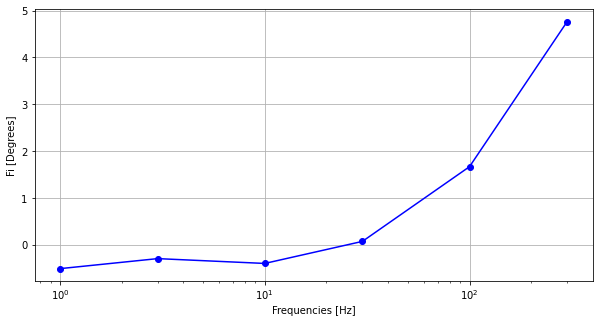

In [86]:
plt.plot(frequencies_results, fi_results, "bo-")
plt.xlabel("Frequencies [Hz]")
plt.ylabel("Fi [Degrees]")
plt.grid()
plt.xscale("log")
plt.show()

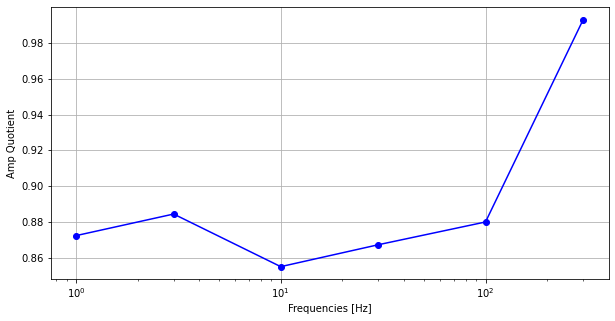

In [85]:
plt.plot(frequencies_results, amp_quotient_results, "bo-")
plt.xlabel("Frequencies [Hz]")
plt.ylabel("Amp Quotient")
plt.grid()
plt.xscale("log")
plt.show()